# GroupBy

**Prerequisites**

- [Functions](../python_fundamentals/functions.ipynb)  
- pandas introduction [1](intro.ipynb) and [2](basics.ipynb)  
- [Reshape](reshape.ipynb)  


**Outcomes**

- Understand the split-apply-combine strategy for aggregate
  computations on groups of data  
- Be able use basic aggregation methods on `df.groupby` to compute
  within group statistics  
- Understand how to group by multiple keys at once  


**Data**

- Details for all delayed US domestic flights in December 2016,
  obtained from the [Bureau of Transportation
  Statistics](https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236&DB_Short_Name=On-Time)  

In [2]:
1+1

2

In [3]:
# Uncomment following line to install on colab
# %pip install qeds

In [4]:
import random
import numpy as np
import pandas as pd
import qeds
import matplotlib.pyplot as plt

%matplotlib inline
# activate plot theme
import qeds
qeds.themes.mpl_style();

## Outline

- [GroupBy](#GroupBy)  
  - [Split-Apply-Combine](#Split-Apply-Combine)  
  - [Case Study: Airline Delays](#Case-Study:-Airline-Delays)  
  - [Exercise: Cohort Analysis using Shopify Data](#Exercise:-Cohort-Analysis-using-Shopify-Data)  
  - [Exercises](#Exercises)  

## Split-Apply-Combine

One powerful paradigm for analyzing data is the “Split-Apply-Combine”
strategy

This strategy has three steps:

1. `Split`: split the data into groups based on values in one or more columns.  
1. `Apply`: apply a function or routine to each group separately.  
1. `Combine`: combine the output of the apply step into a DataFrame,
  using the group identifiers as the index  

We will cover the core concepts here

We **strongly** encourage you
to also study the [official
documentation](https://pandas.pydata.org/pandas-docs/stable/groupby.html)

To describe the concepts, we will need some data

We'll start with artificial data and then use a real-world dataset

In [5]:
C = np.arange(1, 7, dtype=float)
C[[3, 5]] = np.nan
df = pd.DataFrame({
    "A" : [1, 1, 1, 2, 2, 2],
    "B" : [1, 1, 2, 2, 1, 1],
    "C": C,
})
df

,A,B,C
0,1,1,1.0
1,1,1,2.0
2,1,2,3.0
3,2,2,NaN
4,2,1,5.0
5,2,1,NaN


### First Example


To perform the **Split** step, we call the `groupby` method on our
DataFrame

First argument to `groupby` is how we want to form group

The most basic form of splitting is to use a single column

In [6]:
gbA = df.groupby("A")

`gbA` has type `DataFrameGroupBy`:

In [7]:
type(gbA)

pandas.core.groupby.generic.DataFrameGroupBy

We usually refer to this type as `GroupBy` for short

We use `gb.get_group(group_name)` for the group with value `group_name`:

In [8]:
gbA.get_group(1)

,A,B,C
0,1,1,1.0
1,1,1,2.0
2,1,2,3.0


In [9]:
gbA.get_group(2)

,A,B,C
3,2,2,NaN
4,2,1,5.0
5,2,1,NaN


Note that we used the *values* in the `A` column to access groups

<a id='exercise-0'></a>
**Exercise 1**

We can *apply* some of our favorite aggregation functions directly on the
`GroupBy` object

Look closely at the output of the cells below

How did pandas compute the sum of `gbA`? What happened to the `NaN`
entries in column `C`?

Write your thoughts

Hint: try `gbA.count()` or `gbA.mean()` if you can’t decide what
happened to the `NaN`

In [5]:
df

,A,B,C
0,1,1,1.0
1,1,1,2.0
2,1,2,3.0
3,2,2,NaN
4,2,1,5.0
5,2,1,NaN


In [6]:
gbA.sum()

,B,C
A,,
1,4,6.0
2,4,5.0



<a id='exercise-1'></a>
**Exercise 2**

Use introspection (tab completion) to see what other aggregations are
defined for GroupBy objects.

Pick three and evaluate them in the cells below.

Does the output of each of these commands have the same features as the
output of `gbA.sum()` from above? If not, what is different?

In [ ]:
# method 1

In [ ]:
# method 2

In [ ]:
# method 3

We can also group by multiple columns

How?  pass a list of strings to `groupby`

DataFrame will be split into collections of rows with unique combinations of requested columns

In [9]:
gbAB = df.groupby(["A", "B"])
type(gbAB)

pandas.core.groupby.generic.DataFrameGroupBy

In [23]:
# all rows below have A = 1 AND B = 1
gbAB.get_group((1, 1))

,A,B,C
0,1,1,1.0
1,1,1,2.0


Notice that we still have a GroupBy object, so we can apply our favorite
aggregations.

In [ ]:
gbAB.count()

Notice that the output is a DataFrame with two levels on the index
and a single column `C`. (Quiz: how do we know it is a DataFrame with
one column and not a Series?)

This highlights a principle of how pandas handles the *Combine* part of
the strategy:

> The index of the combined DataFrame will be the group identifiers,
with one index level per group key

### Custom Aggregate Functions

So far, we have been applying built-in aggregations to our GroupBy object

We can also apply custom aggregations to each group of a GroupBy in two
steps:

1. Write our custom aggregation as a Python function
1. Passing our function as an argument to the `.agg` method of a GroupBy  

Let's try it!

In [12]:
def num_missing(df):
    "Return the number of missing items in each column of df"
    return df.isnull().sum()

We can call this function on our original DataFrame to get the number of
missing items in each column

In [13]:
num_missing(df)

A    0
B    0
C    2
dtype: int64

We can also apply it to a GroupBy object to get the number of missing
items in each column *for each group*

In [14]:
gbA.agg(num_missing)

,B,C
A,,
1,0,0.0
2,0,2.0


The function we write should either

- Consume `DataFrame` and return `Series`
- Consume `Series`  and return `scalar`

Pandas calls the function for each group

For DataFrames, the function is called separately for each column

### Transforms: The `apply` Method

As we saw in the [basics lecture](basics.ipynb), we can apply transforms to DataFrames

We can do the same with GroupBy objects using the `.apply` method

Let’s see an example

In [15]:
df

,A,B,C
0,1,1,1.0
1,1,1,2.0
2,1,2,3.0
3,2,2,NaN
4,2,1,5.0
5,2,1,NaN


In [16]:
def smallest_by_b(df):
    return df.nsmallest(2, "B")

In [17]:
gbA.apply(smallest_by_b)

B    C
A          
1 0  1  1.0
  1  1  2.0
2 4  1  5.0
  5  1  NaN

**NOTE**: The return value above has a two-level index

1. The value of `A`
2. The index from the original DataFrame

The second layer carried the original DataFrames's index because `smallest_by_b` kept the original index in its return value

If `smallest_by_b` returned a different index, that would have shown up in `gbA.apply(smallest_by_b)`

<a id='exercise-2'></a>
**Exercise 3**

This exercise has a few steps:

1. Write a function that, given a DataFrame, computes each entry’s deviation from the mean of its column
2. Apply the function to `gbA`
3. With your neighbor describe what the index and and columns are? Where are the group keys (the `A` column)?
4. Determine the correct way to add these results back into `df` as new columns (Hint: remember the [merge](merge.ipynb) lecture)

In [ ]:
# write function here


# apply function here

In [ ]:
# add output of function as new columns to df here...

### `pd.Grouper`

Columns don't always contain desired groups

Some examples are:

- Grouping by a column and a level of the index  
- Grouping time series data at a particular frequency  

pandas lets you do this through the `pd.Grouper` type

To see it in action, let’s make a copy of `df` with `A` moved to the
index and a `Date` column added

In [18]:
df2 = df.copy()
df2["Date"] = pd.date_range(
    start=pd.datetime.today().strftime("%m/%d/%Y"),
    freq="BQ",
    periods=df.shape[0]
)
df2 = df2.set_index("A")
df2

/home/sglyon/anaconda3/envs/qeds/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,B,C,Date
A,,,
1,1,1.0,2020-09-30
1,1,2.0,2020-12-31
1,2,3.0,2021-03-31
2,2,NaN,2021-06-30
2,1,5.0,2021-09-30
2,1,NaN,2021-12-31


We can group by year

In [19]:
df2.groupby(pd.Grouper(key="Date", freq="A")).count()

,B,C
Date,,
2020-12-31,2,2
2021-12-31,4,2


We can group by the `A` level of the index

In [20]:
df2.groupby(pd.Grouper(level="A")).count()

,B,C,Date
A,,,
1,3,3,3
2,3,1,3


We can combine these to group by both

In [21]:
df2.groupby([pd.Grouper(key="Date", freq="A"), pd.Grouper(level="A")]).count()

B  C
Date       A      
2020-12-31 1  2  2
2021-12-31 1  1  1
           2  3  1

And we can combine `pd.Grouper` with a string, where the string
denotes a column name

In [ ]:
df2.groupby([pd.Grouper(key="Date", freq="A"), "B"]).count()

## Case Study: Airline Delays

Let's practice on some real data!

We'll revisit the airline dataset from the [merge](merge.ipynb) lecture

In [10]:
air_dec = qeds.load("airline_performance_dec16")

First, we compute the average delay in arrival time for all carriers
each week

In [11]:
weekly_delays = (
    air_dec
    .groupby([pd.Grouper(key="Date", freq="W"), "Carrier"])
    ["ArrDelay"]               # extract one column
    .mean()                    # take average
    .unstack(level="Carrier")  # Flip carrier up as column names
)
weekly_delays

Carrier,AA,AS,B6,DL,EV,F9,HA,NK,OO,UA,VX,WN
Date,,,,,,,,,,,,
2016-12-04,-1.714887,2.724273,-2.894269,-5.088351,8.655332,-2.894212,-0.558282,5.468909,2.749573,5.564496,-2.121821,-1.663695
2016-12-11,1.148833,12.052031,5.795062,2.507745,13.220673,4.578861,2.054302,8.713755,15.429660,4.094176,12.080938,1.865933
2016-12-18,16.357561,7.643767,34.608356,18.000000,23.876622,45.014888,9.388889,22.857899,30.901639,22.398130,33.651128,18.373400
2016-12-25,6.364513,2.719699,5.586836,-0.916113,6.857143,54.084959,5.075747,10.443369,15.004780,5.332474,17.286917,10.197685
2017-01-01,2.321836,1.226662,10.661577,2.048116,6.800898,8.280298,6.970016,8.361123,8.971083,0.061786,1.349580,5.213019


Let’s also plot this data

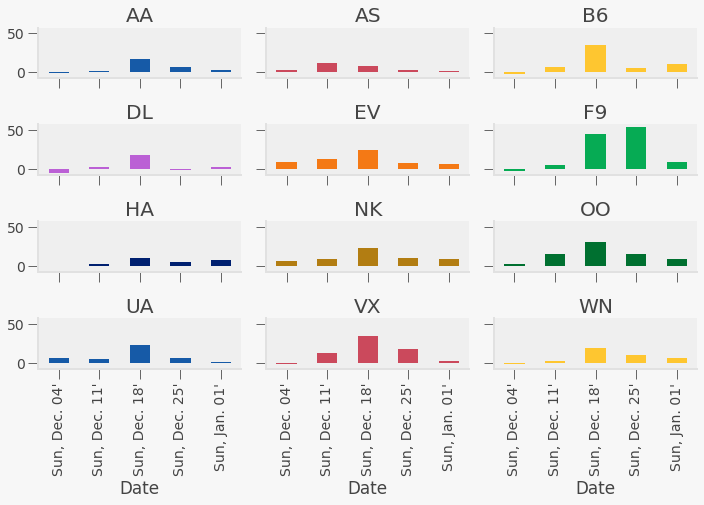

In [12]:
# plot
axs = weekly_delays.plot.bar(
    figsize=(10, 8), subplots=True, legend=False, sharex=True,
    sharey=True, layout=(4, 3), grid=False
)

# tweak spacing between subplots and xaxis labels
axs[0,0].get_figure().tight_layout()
for ax in axs[-1, :]:
    ax.set_xticklabels(weekly_delays.index.strftime("%a, %b. %d'"))

Most delayed week ended on Sunday December (except for Frontier, who did *worse* on week of 25th)

Let’s see why...

The `air_dec` DataFrame has information on the minutes of delay
attributed to 5 different categories:

In [13]:
delay_cols = [
    'CarrierDelay',
    'WeatherDelay',
    'NASDelay',
    'SecurityDelay',
    'LateAircraftDelay'
]

Let’s take a quick look at each of those delay categories for the week ending December 18, 2016

In [14]:
pre_christmas = air_dec.loc[
    (air_dec["Date"] >= "2016-12-12") & (air_dec["Date"] <= "2016-12-18")
]

# custom agg function
def positive(df):
    return (df > 0).sum()

delay_totals = pre_christmas.groupby("Carrier")[delay_cols].agg(["sum", "mean", positive])
delay_totals

CarrierDelay                     WeatherDelay                     \
                 sum       mean positive          sum      mean positive   
Carrier                                                                    
AA          105732.0   6.258553   2922.0      21820.0  1.291583    456.0   
AS            8762.0   2.691032    250.0       3219.0  0.988636     61.0   
B6           49421.0   9.031615   1575.0       9894.0  1.808114    112.0   
DL          151188.0   8.864212   2878.0      39145.0  2.295087    783.0   
EV           87408.0   9.939504   1375.0       3824.0  0.434842     76.0   
F9           19568.0  10.430704    361.0       6198.0  3.303838     57.0   
HA            7199.0   5.034266    218.0       3650.0  2.552448    145.0   
NK           14735.0   5.294646    452.0       2240.0  0.804887     56.0   
OO          120307.0  10.439691   1378.0      26349.0  2.286446    308.0   
UA           66693.0   6.312636   1851.0      31602.0  2.991197    521.0   
VX            8048.0   5.608362    246.0       3807.0  2.652962    126.0   
WN          123882.0   4.873790   5393.0      23516.0  0.925171    328.0   

        NASDelay                     SecurityDelay                     \
             sum       mean positive           sum      mean positive   
Carrier                                                                 
AA       77279.0   4.574346   3159.0         721.0  0.042678     35.0   
AS       16344.0   5.019656    614.0         163.0  0.050061     10.0   
B6       38741.0   7.079861   1326.0         672.0  0.122807     30.0   
DL       75110.0   4.403729   2605.0         107.0  0.006273      2.0   
EV       49703.0   5.651922   1580.0           0.0  0.000000      0.0   
F9       22459.0  11.971748    493.0           0.0  0.000000      0.0   
HA          86.0   0.060140      4.0          35.0  0.024476      3.0   
NK       30361.0  10.909450    840.0          50.0  0.017966      5.0   
OO       54141.0   4.698108   2289.0         171.0  0.014839     12.0   
UA       74992.0   7.098154   2065.0           0.0  0.000000      0.0   
VX       12619.0   8.793728    224.0          73.0  0.050871      4.0   
WN       78645.0   3.094067   4247.0         252.0  0.009914     18.0   

        LateAircraftDelay                      
                      sum       mean positive  
Carrier                                        
AA               141249.0   8.360897   2574.0  
AS                13599.0   4.176597    271.0  
B6               100811.0  18.423063   1433.0  
DL               122896.0   7.205441   2289.0  
EV                89773.0  10.208438   1568.0  
F9                32236.0  17.183369    316.0  
HA                 4024.0   2.813986    189.0  
NK                22247.0   7.993891    372.0  
OO               166102.0  14.413572   2459.0  
UA               118728.0  11.237861   1696.0  
VX                25242.0  17.590244    331.0  
WN               285073.0  11.215399   6472.0

**Want**: plot total, average, and number of each type of delay by
carrier

To do this, we need to have a DataFrame with:

- Delay type in index (so it is on horizontal-axis)  
- Aggregation method on *outer* most level of columns (so we can do
  `data["mean"]` to get averages)  
- Carrier name on inner level of columns  

Many sequences of the reshaping commands can accomplish this

We show one example below

In [15]:
reshaped_delays = (
    delay_totals
    .stack()             # move aggregation method into index (with Carrier)
    .T                   # put delay type in index and Carrier+agg in column
    .swaplevel(axis=1)   # make agg method outer level of column label
    .sort_index(axis=1)  # sort column labels so it prints nicely
)
reshaped_delays

mean                                            \
Carrier                  AA        AS         B6        DL         EV   
CarrierDelay       6.258553  2.691032   9.031615  8.864212   9.939504   
WeatherDelay       1.291583  0.988636   1.808114  2.295087   0.434842   
NASDelay           4.574346  5.019656   7.079861  4.403729   5.651922   
SecurityDelay      0.042678  0.050061   0.122807  0.006273   0.000000   
LateAircraftDelay  8.360897  4.176597  18.423063  7.205441  10.208438   

                                                                         ...  \
Carrier                   F9        HA         NK         OO         UA  ...   
CarrierDelay       10.430704  5.034266   5.294646  10.439691   6.312636  ...   
WeatherDelay        3.303838  2.552448   0.804887   2.286446   2.991197  ...   
NASDelay           11.971748  0.060140  10.909450   4.698108   7.098154  ...   
SecurityDelay       0.000000  0.024476   0.017966   0.014839   0.000000  ...   
LateAircraftDelay  17.183369  2.813986   7.993891  14.413572  11.237861  ...   

                        sum                                               \
Carrier                  B6        DL       EV       F9      HA       NK   
CarrierDelay        49421.0  151188.0  87408.0  19568.0  7199.0  14735.0   
WeatherDelay         9894.0   39145.0   3824.0   6198.0  3650.0   2240.0   
NASDelay            38741.0   75110.0  49703.0  22459.0    86.0  30361.0   
SecurityDelay         672.0     107.0      0.0      0.0    35.0     50.0   
LateAircraftDelay  100811.0  122896.0  89773.0  32236.0  4024.0  22247.0   

                                                          
Carrier                  OO        UA       VX        WN  
CarrierDelay       120307.0   66693.0   8048.0  123882.0  
WeatherDelay        26349.0   31602.0   3807.0   23516.0  
NASDelay            54141.0   74992.0  12619.0   78645.0  
SecurityDelay         171.0       0.0     73.0     252.0  
LateAircraftDelay  166102.0  118728.0  25242.0  285073.0  

[5 rows x 36 columns]

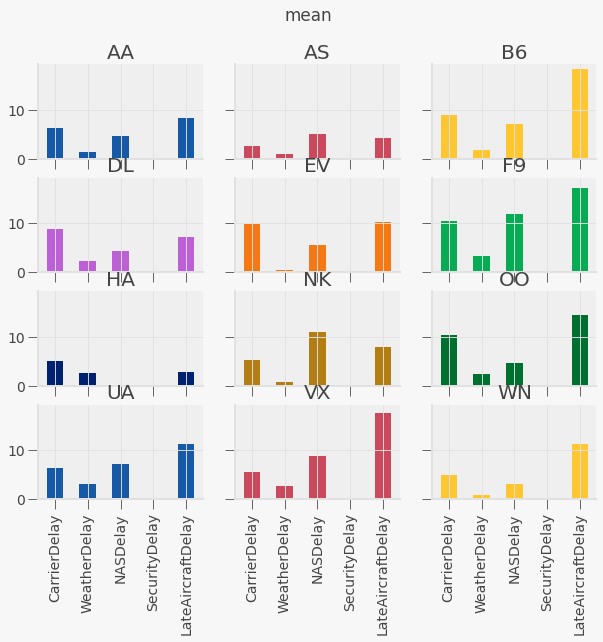

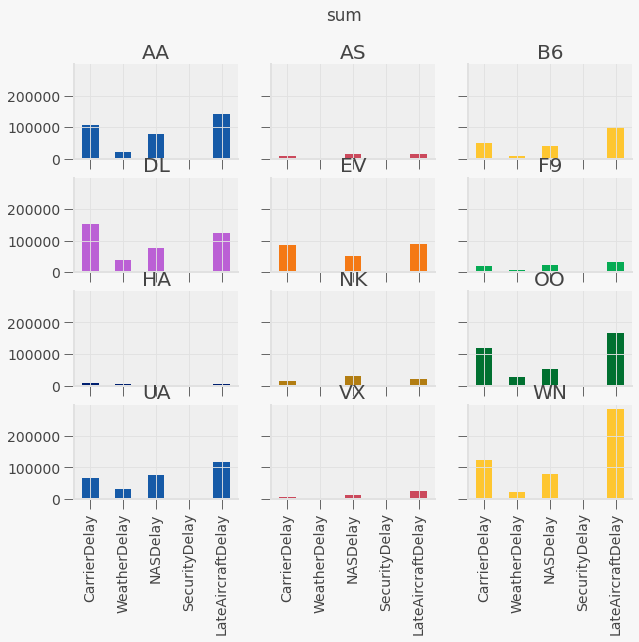

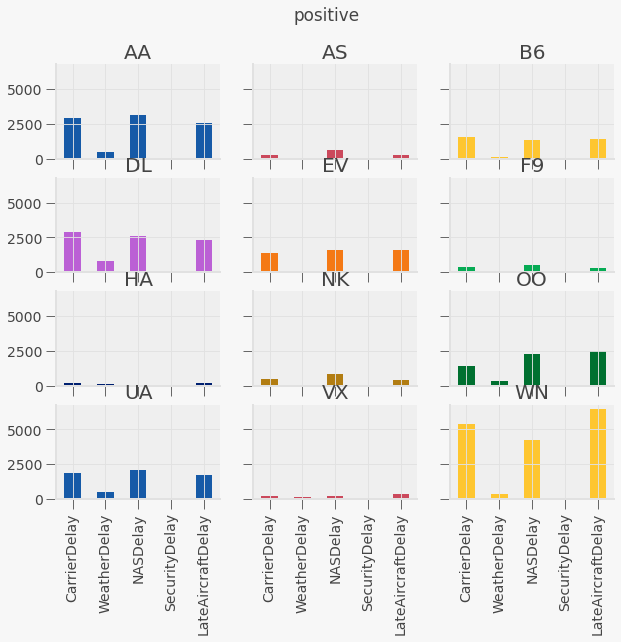

In [16]:
for agg in ["mean", "sum", "positive"]:
    axs = reshaped_delays[agg].plot(
        kind="bar", subplots=True, layout=(4, 3), figsize=(10, 8), legend=False,
        sharex=True, sharey=True
    )
    fig = axs[0, 0].get_figure()
    fig.suptitle(agg)
#     fig.tight_layout();


<a id='exercise-3'></a>
**Exercise 4**

Think about what is shown in the the plots above

Answer questions like:

- Which type of delay was the most common?  
- Which one caused the largest average delay?  
- Does that vary by airline?  


Write your thoughts

In [17]:
# your code here if needed

Let’s summarize what we did:

- Computed average flight delay for each airline for each week  
- Noticed that one week had more delays for all airlines
- Studied the flights in that week to determine the *cause* of the
  delays in that week

Suppose now that we want to repeat that analysis, but at a daily
frequency instead of weekly

We could copy/paste the code from above and change the `W` to a `D`,
but there’s a better way…

Let’s convert the steps above into two functions:

1. Produce the set of bar charts for average delays at each frequency 
1. Produce the second set of charts for the total, average, and number of occurrences of each type of delay

In [18]:
def mean_delay_plot(df, freq, figsize=(10, 8)):
    """
    Make a bar chart of average flight delays for each carrier at
    a given frequency.
    """
    mean_delays = (
        df
        .groupby([pd.Grouper(key="Date", freq=freq), "Carrier"])
        ["ArrDelay"]               # extract one column
        .mean()                    # take average
        .unstack(level="Carrier")  # Flip carrier up as column names
    )

    # plot
    axs = mean_delays.plot.bar(
        figsize=figsize, subplots=True, legend=False, sharex=True,
        sharey=True, layout=(4, 3), grid=False
    )

    # tweak spacing between subplots and x-axis labels
    axs[0, 0].get_figure().tight_layout()
    for ax in axs[-1, :]:
        ax.set_xticklabels(mean_delays.index.strftime("%a, %b. %d'"))

    # return the axes in case we want to further tweak the plot outside the function
    return axs

In [19]:
def delay_type_plot(df, start, end):
    """
    Make bar charts for total minutes, average minutes, and number of
    occurrences for each delay type, for all flights that were scheduled
    between `start` date and `end` date
    """
    sub_df = df.loc[
        (df["Date"] >= start) & (df["Date"] <= end)
    ]

    def positive(df):
        return (df > 0).sum()

    aggs = sub_df.groupby("Carrier")[delay_cols].agg(["sum", "mean", positive])

    reshaped = aggs.stack().T.swaplevel(axis=1).sort_index(axis=1)

    for agg in ["mean", "sum", "positive"]:
        axs = reshaped[agg].plot(
            kind="bar", subplots=True, layout=(4, 3), figsize=(10, 8), legend=False,
            sharex=True, sharey=True
        )
        fig = axs[0, 0].get_figure()
        fig.suptitle(agg)
#         fig.tight_layout();


<a id='exercise-4'></a>
**Exercise 5**

Verify that we wrote the functions properly by setting the arguments to
appropriate values to replicate the plots from above.

In [20]:
# call mean_delay_plot here

In [21]:
# call delay_type_plot here

Now let’s look at that plot at a daily frequency

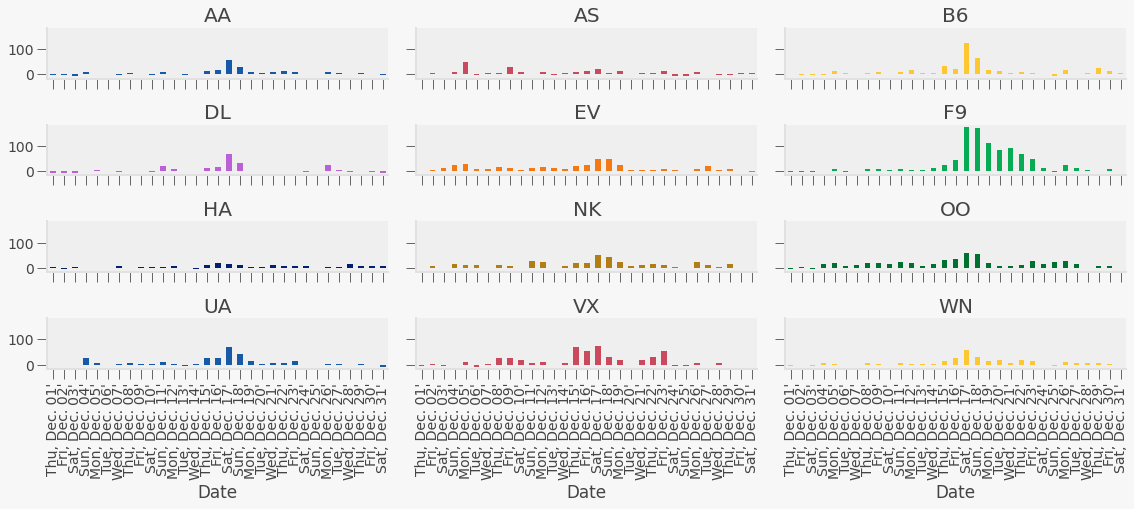

In [22]:
# figure needs to be a bit wider to see all the dates
mean_delay_plot(air_dec, "D", figsize=(16, 8));

As we expected given our analysis above, the longest average delays
seemed to happen in the third week

In particular, it looks like December 17th and 18th had — on average —
higher delays than other days in December

Let’s use the `delay_type_plot` function to determine the cause of the
delays on those two days

Because our analysis is captured in a single function, we can look at
the days together and separately without much effort

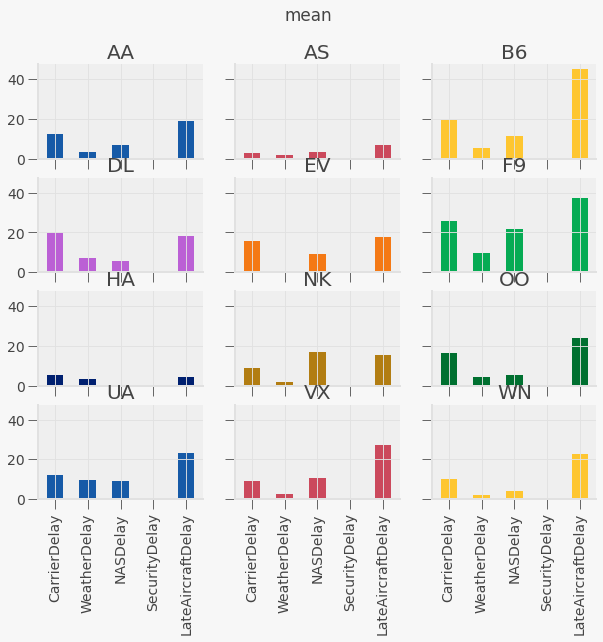

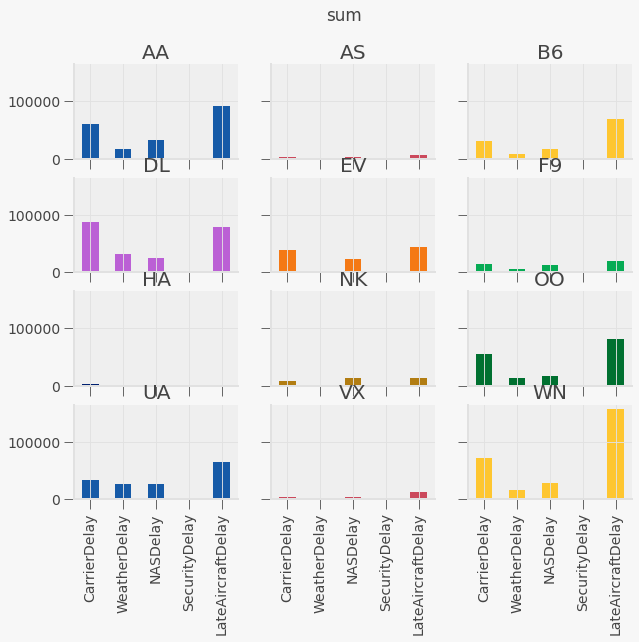

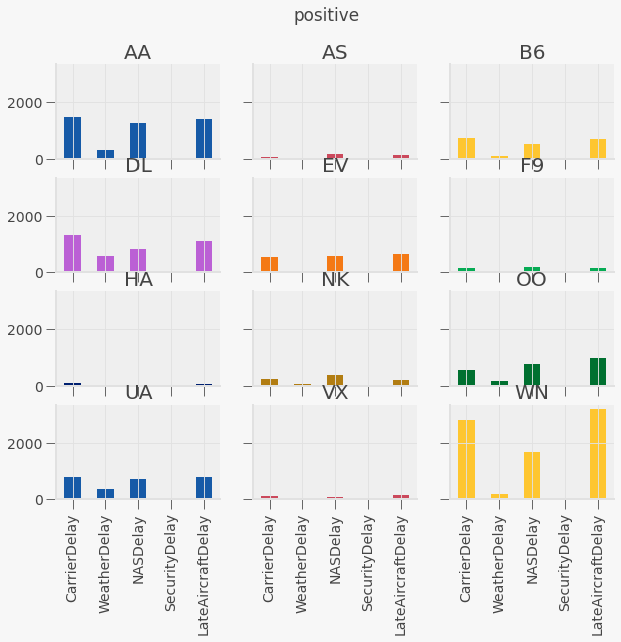

In [23]:
# both days
delay_type_plot(air_dec, "12-17-16", "12-18-16")

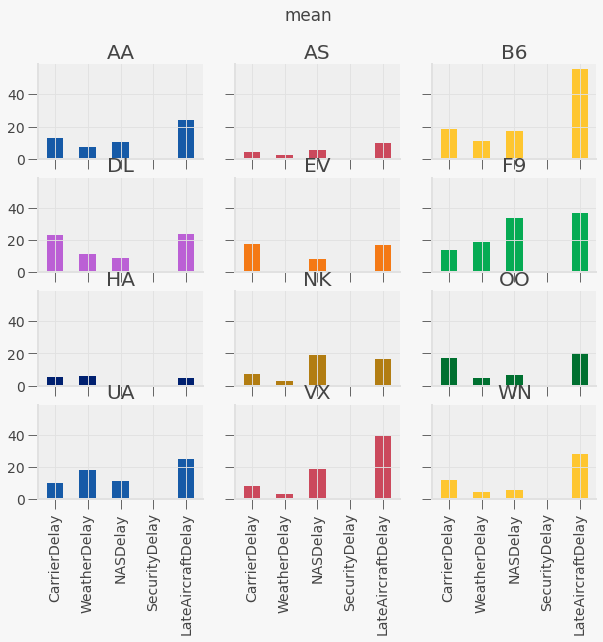

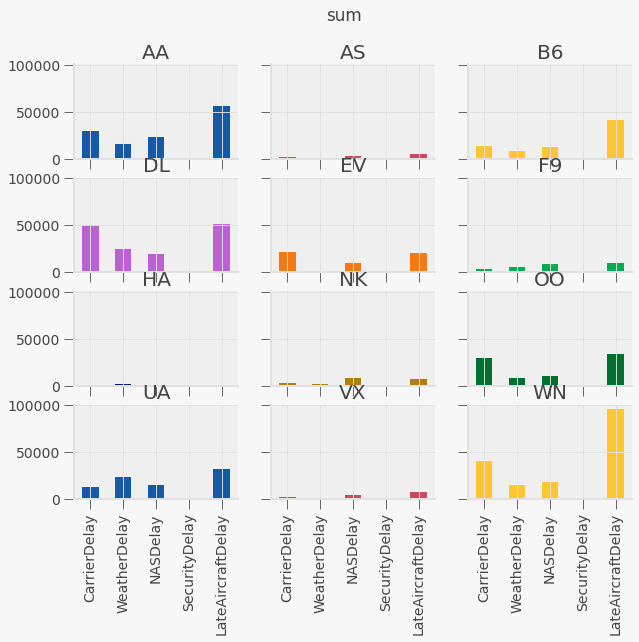

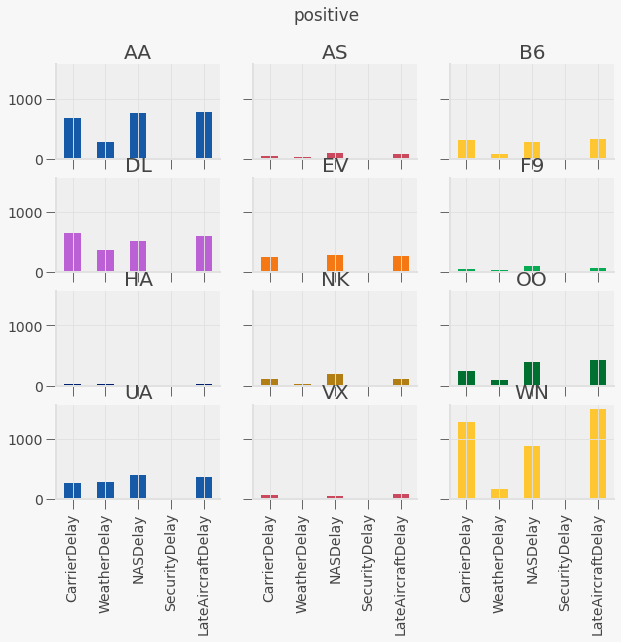

In [24]:
# only the 17th
delay_type_plot(air_dec, "12-17-16", "12-17-16")

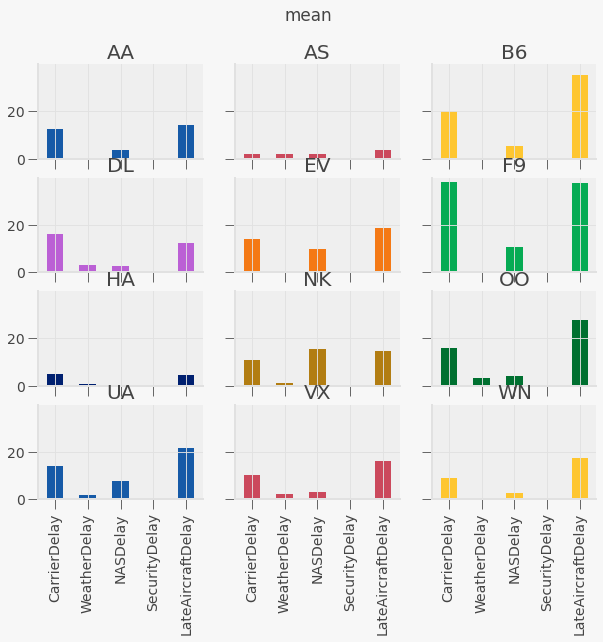

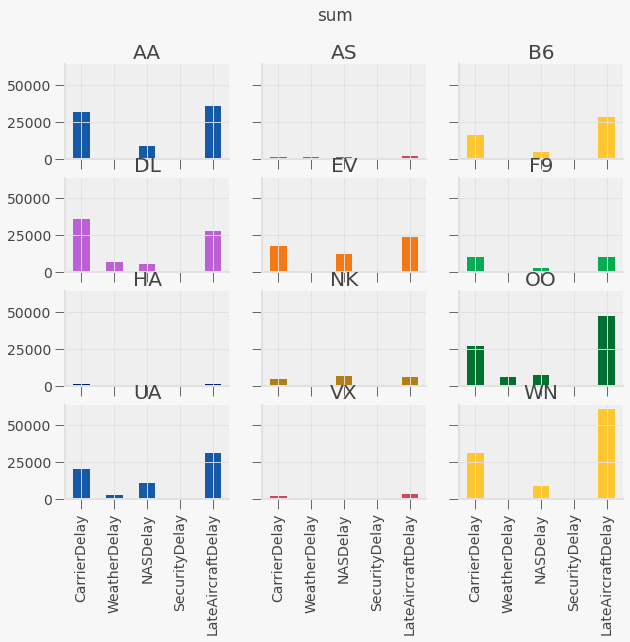

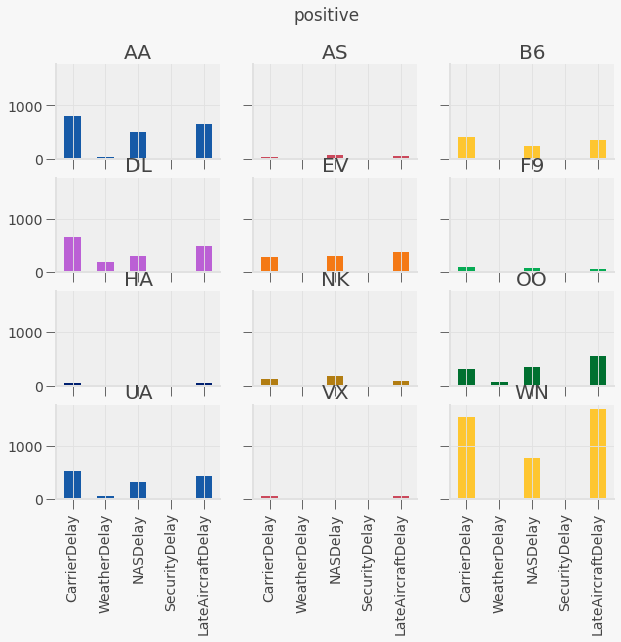

In [26]:
# only the 18th
delay_type_plot(air_dec, "12-18-16", "12-18-16")

- The purpose of this exercise was to drive home the ability to *automate* tasks
- We wrote a pair of `functions` that allow us to easily repeat the exact same analysis on different subsets of the data, or different datasets entirely (e.g. we could do the same analysis on November 2016 data, with two lines of code)
- These principles can be applied in many settings
- Keep that in mind as we work through the rest of the materials

## Exercise: Cohort Analysis using Shopify Data

The `qeds` library includes routines to simulate data sets in the
format of common sources

One of these sources is [Shopify](https://www.shopify.com/) — an
e-commerce platform used by many retail companies for online sales

The code below will simulate a fairly large data set that has the
properties of a order-detail report from Shopify

We’ll first look at the data, and then describe the exercise

In [27]:
# Set the "randomness" seeds
random.seed(42)
np.random.seed(42)

orders = qeds.data.shopify.simulate_orders(500000)
orders.info()

orders.head()

/Users/sglyon/anaconda3/envs/qeds/lib/python3.8/site-packages/qeds/data/shopify.py:106: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  end_date = pd.datetime.now().strftime("%Y-%m-%d")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501522 entries, 0 to 501521
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Day                501522 non-null  object 
 1   customer_type      501522 non-null  object 
 2   Customer ID        501522 non-null  int64  
 3   orders             501522 non-null  int64  
 4   total_sales        501522 non-null  float64
 5   Returns            501522 non-null  float64
 6   Ordered quantity   501522 non-null  int64  
 7   Gross sales        501522 non-null  float64
 8   Net sales          501522 non-null  float64
 9   Shipping           501522 non-null  float64
 10  Tax                501522 non-null  float64
 11  Net quantity       501522 non-null  int64  
 12  Returned quantity  501522 non-null  int64  
 13  Discounts          501522 non-null  float64
dtypes: float64(7), int64(5), object(2)
memory usage: 53.6+ MB


,Day,customer_type,Customer ID,orders,total_sales,Returns,Ordered quantity,Gross sales,Net sales,Shipping,Tax,Net quantity,Returned quantity,Discounts
0,2020-03-18,Returning,1825044237,1,66.02,-0.0,7,66.02,66.02,0.0,0.00,7,0,-0.0
1,2015-11-30,Returning,5738410335,1,3.91,-0.0,2,3.45,3.45,0.0,0.46,2,0,-0.0
2,2015-01-22,First-time,8183772638,1,62.25,-0.0,7,62.25,62.25,0.0,0.00,7,0,-0.0
3,2014-04-26,First-time,661927852,1,153.78,-0.0,3,153.78,153.78,0.0,0.00,3,0,-0.0
4,2020-05-31,Returning,5481518024,1,13.51,-0.0,1,13.51,13.51,0.0,0.00,1,0,-0.0


**Definition:** A customer’s cohort is the month in which a customer placed
their first order

The customer type column indicates whether order was placed by a new or returning customer

We now describe the *want* for the exercise, which we ask you to complete

**Want**: Compute the monthly total number of orders, total sales, and
total quantity separated by customer cohort and customer type

Read that carefully one more time…

### Extended Exercise

Using the reshape and `groupby` tools you have learned, apply the want
operator described above

See below for advice on how to proceed

When you are finished, you should have something that looks like this:

<img src="https://datascience.quantecon.org/assets/_static/groupby_files/groupby_cohort_analysis_exercise_output.png" alt="groupby\_cohort\_analysis\_exercise\_output.png" style="">

  

Two notes on the table above:

1. Your actual output will be much bigger. This is just to give you an idea of what it might look like
1. The numbers you produce should actually be the same as what are included in this table… Index into your answer and compare what you have with this table to verify your progress  

Now, how to do it?

There is more than one way to code this, but here are some suggested
steps.

1. Convert the `Day` column to have a `datetime` `dtype` instead of object (Hint: use the `pd.to_datetime` function)
1. Add a new column that specifies the date associated with each
  customer’s `"First-time"` order
  - Hint 1: You can do this with a combination of `groupby` and
    `join`
  - Hint 2: `customer_type` is always one of `Returning` and
    `First-time`  
  - Hint 3: Some customers don’t have a
    `customer_type == "First-time"` entry. You will need to set the
    value for these users to some date that precedes the dates in the
    sample. After adding valid data back into `orders` DataFrame,
    you can identify which customers don’t have a `"First-Time"`
    entry by checking for missing data in the new column.  
1. You’ll need to group by 3 things  
1. You can apply one of the built-in aggregation functions to the GroupBy
1. After doing the aggregation, you’ll need to use your reshaping skills to
  move things to the right place in rows and columns


Good luck!